# Set up example code

## Model setup

In [1]:
import subprocess

from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.gaussian_process import kernels
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import matplotlib.cm as cm
import matplotlib.pyplot as plt

from scipy.linalg import lapack
from scipy import stats
import emcee
import numpy as np

import importlib

import os
import pickle
from pathlib import Path

import src.reader as Reader

import pandas as pd

## Step 1: prepare input pickle file

### Load stuff from text files

Input Directory

In [2]:
indir = '/scratch/user/cameron.parker/newJETSCAPE/JETSCAPE/runs/LEP-10-2/QVir_Analysis/'

Prepare to read design to read in

In [3]:
df = pd.read_csv(indir+'parameters.txt')
designlines = ["# 2760\n","# Version 1.0\n","# Parameter ",df.to_string(index=False)]

designfile = open("input/design.txt",'w')
designfile.writelines(designlines)
designfile.close()

RawDesign = Reader.ReadDesign("input/design.txt")
print(RawDesign)

{'FileName': 'input/design.txt', 'Parameter': ['Q0', 'vir_factor', 'lambdaQCD', 'part_prop', 'StringFlav:probStoUD', 'StringFlav:probQQtoQ', 'MultipartonInteractions:ecmPow', 'MultipartonInteractions:pT0Ref'], 'Design': array([[2.401493, 0.391061, 0.390147, ..., 0.175275, 0.148541, 0.972226],
       [1.346016, 0.590684, 0.100628, ..., 0.104714, 0.110772, 0.787971],
       [2.315659, 0.602873, 0.147463, ..., 0.161224, 0.154745, 1.428617],
       ...,
       [1.449672, 0.156187, 0.362594, ..., 0.184953, 0.080752, 1.906607],
       [0.95224 , 0.436785, 0.178326, ..., 0.129807, 0.168944, 1.138764],
       [2.037606, 0.830495, 0.35378 , ..., 0.106363, 0.069009, 1.457613]])}


In [4]:
# Read data files
RawData1 = Reader.ReadData('/scratch/user/cameron.parker/newJETSCAPE/STAT/input/data/epem/charged-xp.dat')
RawData2 = Reader.ReadData('/scratch/user/cameron.parker/newJETSCAPE/STAT/input/data/epem/pion-xp.dat')
RawData3 = Reader.ReadData('/scratch/user/cameron.parker/newJETSCAPE/STAT/input/data/epem/kaon-xp.dat')
RawData4 = Reader.ReadData('/scratch/user/cameron.parker/newJETSCAPE/STAT/input/data/epem/proton-xp.dat')
RawData5 = Reader.ReadData('/scratch/user/cameron.parker/newJETSCAPE/STAT/input/data/epem/mult.dat')
RawData6 = Reader.ReadData('/scratch/user/cameron.parker/newJETSCAPE/STAT/input/data/epem/thrust.dat')

# Read model prediction
RawPrediction1 = Reader.ReadPrediction(indir+'charged-xp.dat')
RawPrediction2 = Reader.ReadPrediction(indir+'pion-xp.dat')
RawPrediction3 = Reader.ReadPrediction(indir+'kaon-xp.dat')
RawPrediction4 = Reader.ReadPrediction(indir+'proton-xp.dat')
RawPrediction5 = Reader.ReadPrediction(indir+'mult.dat')
RawPrediction6 = Reader.ReadPrediction(indir+'thrust.dat')

In [5]:
# xlabel ylabel xlog ylog
plotvars = [
    ["xp","dN/dxp","log","log"],
    ["xp","dN/dxp","log","log"],
    ["xp","dN/dxp","log","log"],
    ["xp","dN/dxp","log","log"],
    ["N","P","linear","log"],
    #["1-thrust","P","linear","linear"]
]

### Data formatting

In [6]:
# Initialize empty dictionary
AllData = {}

# Basic information
AllData["systems"] = ["AuAu200"]
AllData["keys"] = RawDesign["Parameter"]
AllData["labels"] = RawDesign["Parameter"]
AllData["ranges"] = [(0.95, 3.0), (0.1, 1.0), (0.1, 0.4), (0.0, 1.5), (0.2, 0.5), (0.07, 0.2), (0.0, 0.25), (0.5, 2.5)]#, (0.5, 2.0), (0.5, 2.0), (0.5, 2.0)]
AllData["observables"] = [('Vac', ['charged-xp', 
                                   'pion-xp', 
                                   'kaon-xp', 
                                   'proton-xp', 
                                   'mult', 
                                   #'thrust',
                                   ])]

# Data points
Data = {"AuAu200": {"Vac": {"charged-xp": RawData1["Data"], 
                             "pion-xp": RawData2["Data"], 
                             "kaon-xp": RawData3["Data"], 
                             "proton-xp": RawData4["Data"], 
                             "mult": RawData5["Data"], 
                             #"thrust": RawData6["Data"],
                             }}}

# Model predictions
Prediction = {"AuAu200": {"Vac": {"charged-xp": {"Y": RawPrediction1["Prediction"], "x": RawData1["Data"]['x']},
                                   "pion-xp": {"Y": RawPrediction2["Prediction"], "x": RawData2["Data"]['x']},
                                   "kaon-xp": {"Y": RawPrediction3["Prediction"], "x": RawData3["Data"]['x']},
                                   "proton-xp": {"Y": RawPrediction4["Prediction"], "x": RawData4["Data"]['x']},
                                   "mult": {"Y": RawPrediction5["Prediction"], "x": RawData5["Data"]['x']},
                                   #"thrust": {"Y": RawPrediction6["Prediction"], "x": RawData6["Data"]['x']},
                                   }}}


Covariance = Reader.InitializeCovariance(Data)
Covariance["AuAu200"][("Vac", "charged-xp")][("Vac", "charged-xp")] = Reader.EstimateCovariance(RawData1, RawData1, SysLength = {"default": 0.05})
Covariance["AuAu200"][("Vac", "pion-xp")][("Vac", "pion-xp")] = Reader.EstimateCovariance(RawData2, RawData2, SysLength = {"default": 0.05})
Covariance["AuAu200"][("Vac", "kaon-xp")][("Vac", "kaon-xp")] = Reader.EstimateCovariance(RawData3, RawData3, SysLength = {"default": 0.05})
Covariance["AuAu200"][("Vac", "proton-xp")][("Vac", "proton-xp")] = Reader.EstimateCovariance(RawData4, RawData4, SysLength = {"default": 0.05})
Covariance["AuAu200"][("Vac", "mult")][("Vac", "mult")] = Reader.EstimateCovariance(RawData5, RawData5, SysLength = {"default": 0.05})
#Covariance["AuAu200"][("Vac", "thrust")][("Vac", "thrust")] = Reader.EstimateCovariance(RawData6, RawData6, SysLength = {"default": 0.05})

# Assign data to the dictionary
AllData["design"] = RawDesign["Design"]
AllData["model"] = Prediction
AllData["data"] = Data
AllData["cov"] = Covariance
Nobs = len(AllData["observables"][0][1])

# Save to the desired pickle file
with open('input/vac-analysis.p', 'wb') as handle:
    pickle.dump(AllData, handle, protocol = pickle.HIGHEST_PROTOCOL)

### Optional: clean past files

In [7]:
# Clean past MCMC samples
if os.path.exists('cache/mcmc_chain.hdf'):
    os.remove("cache/mcmc_chain.hdf")

# Clean past emulator
for system in AllData["systems"]:
    if os.path.exists('cache/emulator/' + system + ".pkl"):
        os.remove('cache/emulator/' + system + ".pkl")

## Step 2: run emulator

In [8]:
! python3 -m src.emulator --retrain --npc 10

[INFO][emulator] training emulator for system AuAu200 (10 PC, 0 restarts)
[2.05 0.9  0.3  1.5  0.3  0.13 0.25 2.  ]
/scratch/user/cameron.parker/.venv/lib64/python3.6/site-packages/sklearn/gaussian_process/kernels.py:418: ConvergenceWarning: The optimal value found for dimension 4 of parameter k2__length_scale is close to the specified upper bound 3.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
/scratch/user/cameron.parker/.venv/lib64/python3.6/site-packages/sklearn/gaussian_process/kernels.py:418: ConvergenceWarning: The optimal value found for dimension 5 of parameter k2__length_scale is close to the specified upper bound 1.3. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
/scratch/user/cameron.parker/.venv/lib64/python3.6/site-packages/sklearn/gaussian_process/kernels.py:418: ConvergenceWarning: The optimal value found for dimension 6 of parameter k2__length_scale is close to the specified uppe

In [9]:
from src import lazydict, emulator
EmulatorAuAu200 = emulator.Emulator.from_cache('AuAu200')

## Step 3: MCMC sampling

In [10]:
if os.path.exists('cache/mcmc_chain.hdf'):
    os.remove("cache/mcmc_chain.hdf")
! python3 -m src.mcmc --nwalkers 500 --nburnsteps 500 1500

[INFO][mcmc] no existing chain found, starting initial burn-in
[INFO][mcmc] running 500 walkers for 250 steps
[INFO][mcmc] step 25: acceptance fraction: mean 0.2001, std 0.1171, min 0.0000, max 0.5200
[INFO][mcmc] step 50: acceptance fraction: mean 0.1988, std 0.0938, min 0.0000, max 0.4400
[INFO][mcmc] step 75: acceptance fraction: mean 0.1970, std 0.0802, min 0.0000, max 0.3867
[INFO][mcmc] step 100: acceptance fraction: mean 0.1922, std 0.0722, min 0.0000, max 0.3600
[INFO][mcmc] step 125: acceptance fraction: mean 0.1898, std 0.0667, min 0.0000, max 0.3520
[INFO][mcmc] step 150: acceptance fraction: mean 0.1869, std 0.0625, min 0.0000, max 0.3333
[INFO][mcmc] step 175: acceptance fraction: mean 0.1847, std 0.0598, min 0.0000, max 0.3143
[INFO][mcmc] step 200: acceptance fraction: mean 0.1827, std 0.0567, min 0.0000, max 0.3000
[INFO][mcmc] step 225: acceptance fraction: mean 0.1818, std 0.0545, min 0.0044, max 0.2933
[INFO][mcmc] step 250: acceptance fraction: mean 0.1798, std 0.05

## Step 4: Analyze posterior samples

In [11]:
import src
src.Initialize()
from src import mcmc
chain = mcmc.Chain()
MCMCSamples = chain.load()

In [12]:
! python3 -m src.plots posterior gp diag_emu

[INFO][plots] generating plot: posterior
/scratch/user/cameron.parker/newJETSCAPE/STAT/src/plots.py:777: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("Blues"))
  cmap.set_bad('white')
[WARNING][font_manager] findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
[INFO][plots] wrote plots/posterior.pdf
[INFO][plots] generating plot: gp
[INFO][plots] wrote plots/gp.pdf
[INFO][plots] generating plot: diag_emu
[INFO][plots] wrote plots/diag_emu.pdf


## Step 5: adding all sorts of plots

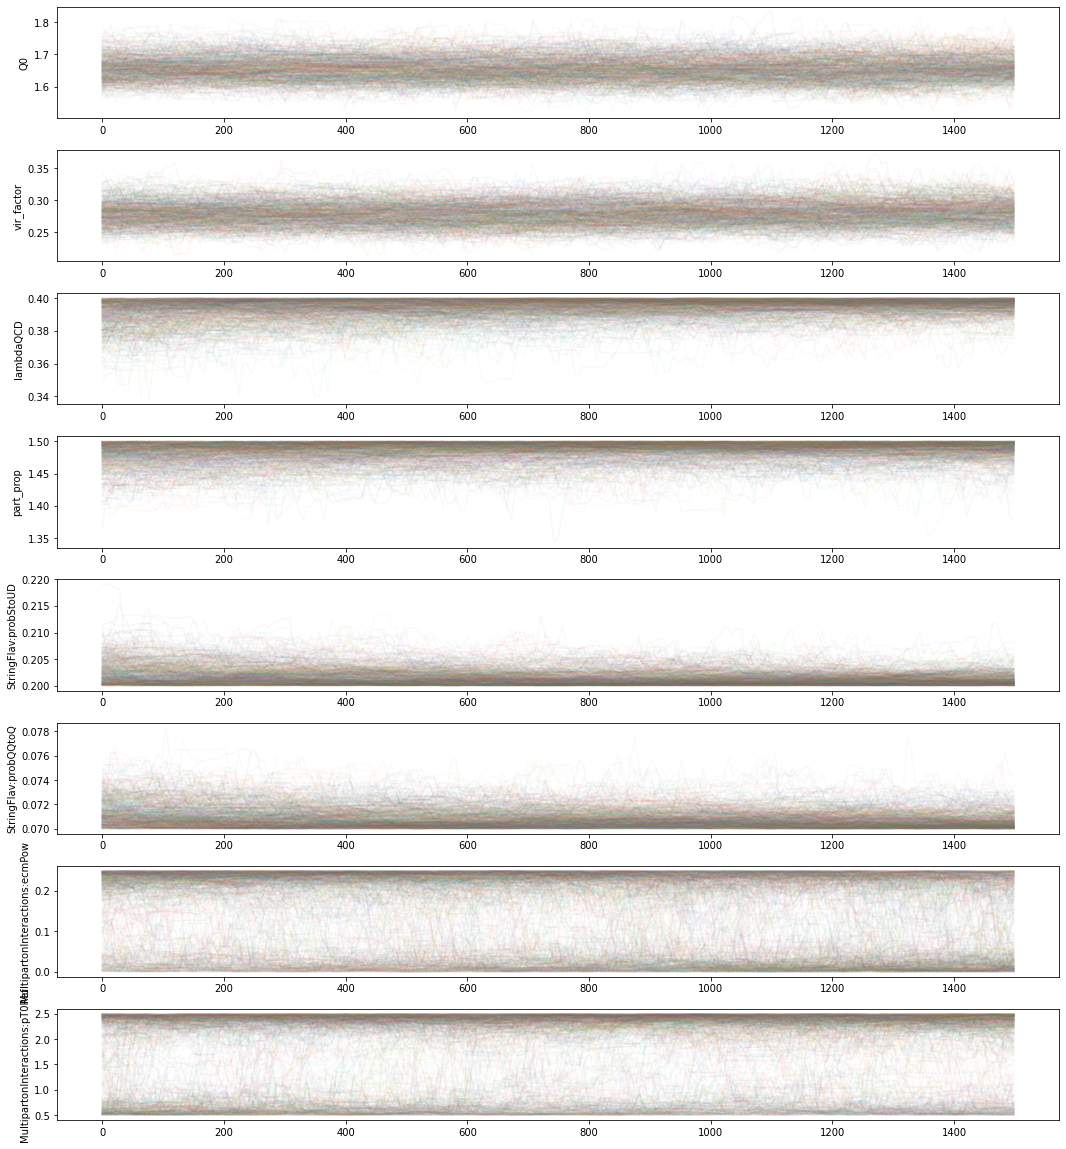

In [13]:
with chain.dataset() as d:
    W = d.shape[0]     # number of walkers
    S = d.shape[1]     # number of steps
    N = d.shape[2]     # number of paramters
    T = int(S / 200)   # "thinning"
    A = 20 / W
    figure, axes = plt.subplots(figsize = (15, 2 * N), ncols = 1, nrows = N)
    for i, ax in enumerate(axes):
        ax.set_ylabel(AllData["labels"][i])
        for j in range(0, W):
            ax.plot(range(0, S, T), d[j, ::T, i], alpha = A)
    plt.tight_layout()
    plt.savefig('plots/MCMCSamples.pdf', dpi = 192)

Parameter Distributions

Q0: 1.6674999999999998
vir_factor: 0.271
lambdaQCD: 0.397
part_prop: 1.4849999999999999
StringFlav:probStoUD: 0.203
StringFlav:probQQtoQ: 0.0713
MultipartonInteractions:ecmPow: 0.2475
MultipartonInteractions:pT0Ref: 2.48


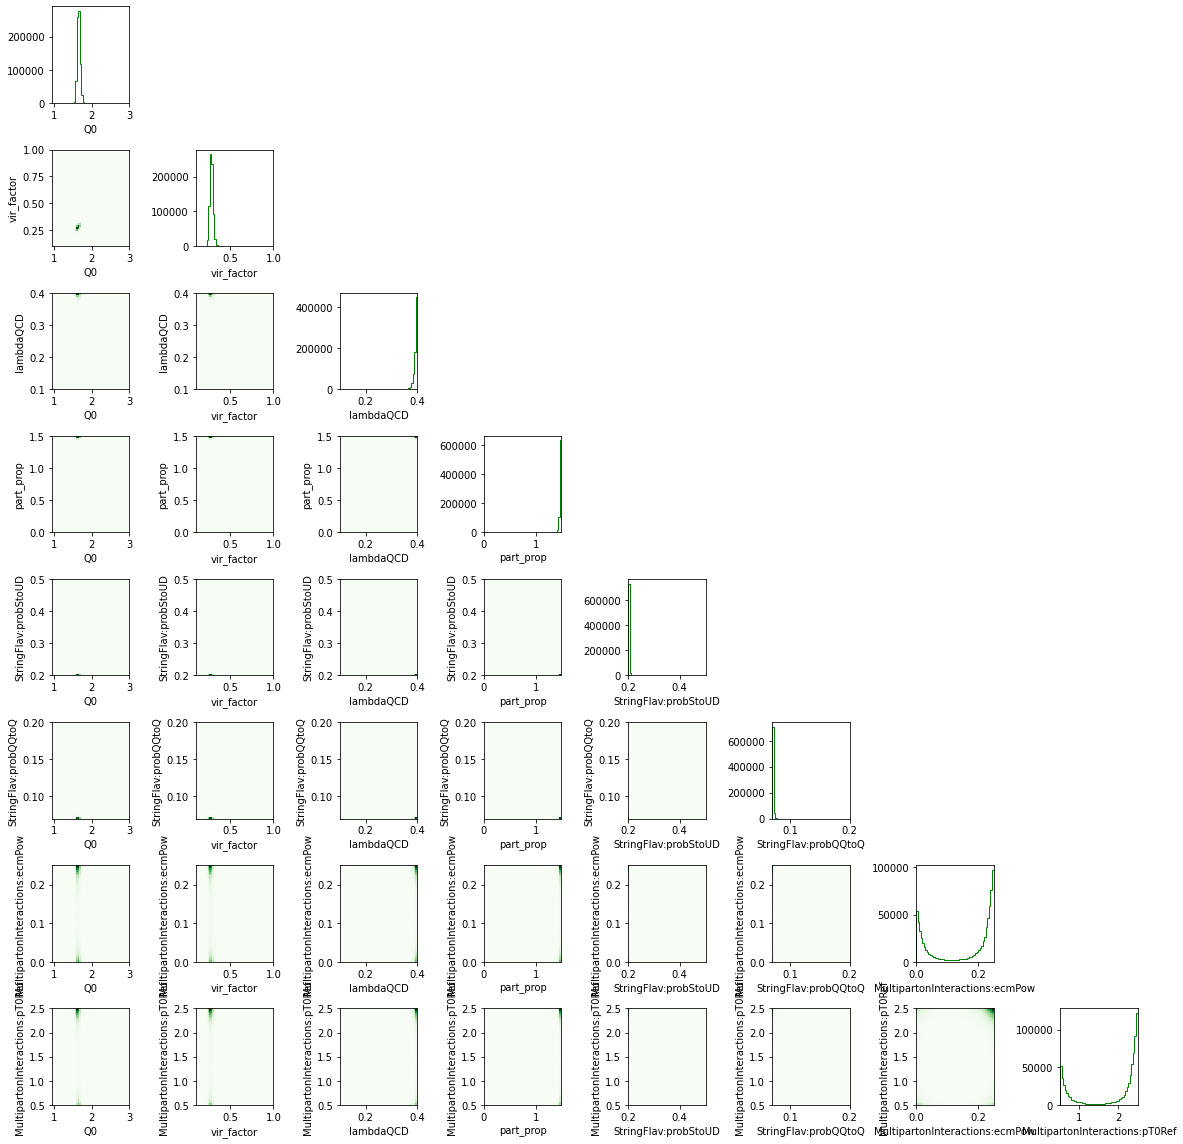

In [27]:
from numpy import average


NDimension = len(AllData["labels"])
Ranges = np.array(AllData["ranges"]).T
scale = 2
figure, axes = plt.subplots(figsize = (scale * NDimension, scale * NDimension), ncols = NDimension, nrows = NDimension)
Names = AllData["labels"]
for i, row in enumerate(axes):
    for j, ax in enumerate(row):
        if i==j:
            y, x, _ = ax.hist(MCMCSamples[:,i], bins=50,
                    range=Ranges[:,i], histtype='step', color='green')
            ax.set_xlabel(Names[i])
            ax.set_xlim(*Ranges[:,j])

            maxindex = 0
            maxy = y.max()
            for k,thisy in enumerate(y): 
                if(thisy == maxy): 
                    maxindex = k

            xmax = (x[maxindex]+x[maxindex+1])/2
            print(AllData["labels"][i] + ": " + str(xmax))
        if i>j:
            ax.hist2d(MCMCSamples[:, j], MCMCSamples[:, i], 
                      bins=50, range=[Ranges[:,j], Ranges[:,i]], 
                      cmap='Greens')
            ax.set_xlabel(Names[j])
            ax.set_ylabel(Names[i])
            ax.set_xlim(*Ranges[:,j])
            ax.set_ylim(*Ranges[:,i])
        if i<j:
            ax.axis('off')

    
plt.tight_layout()
plt.savefig('plots/Correlation.pdf', dpi = 192)
# figure

In [15]:
def makeplot(prediction, plotname):
    Nobs = len(AllData["observables"][0][1])
    figure, axes = plt.subplots(figsize = (3*Nobs, 5), ncols = Nobs, nrows = 2)

    for s2 in range(0, Nobs):
        axes[0][s2].set_title(AllData["observables"][0][1][s2])
        axes[0][s2].set_ylabel(plotvars[s2][1])
        axes[1][s2].set_xlabel(plotvars[s2][0])
        axes[1][s2].set_ylabel(r"ratio")
        
        S1 = AllData["systems"][0]
        O  = AllData["observables"][0][0]
        S2 = AllData["observables"][0][1][s2]
        
        DX = AllData["data"][S1][O][S2]['x']
        DY = AllData["data"][S1][O][S2]['y']
        DE = np.sqrt(AllData["data"][S1][O][S2]['yerr']['stat'][:,0]**2 + AllData["data"][S1][O][S2]['yerr']['sys'][:,0]**2)
                
        if plotname is 'Priors':
            linecount = len(prediction[S1][O][S2]['Y'])
            for i, y in enumerate(prediction[S1][O][S2]['Y']):
                axes[0][s2].plot(DX, y, 'b-', alpha=10/linecount, label=plotname if i==0 else '')
                axes[1][s2].plot(DX, y/DY, 'b-', alpha=10/linecount, label=plotname if i==0 else '')
        else:
            linecount = len(prediction[S1][O][S2])
            for i, y in enumerate(prediction[S1][O][S2]):
                axes[0][s2].plot(DX, y, 'b-', alpha=10/linecount, label=plotname if i==0 else '')
                axes[1][s2].plot(DX, y/DY, 'b-', alpha=10/linecount, label=plotname if i==0 else '')
        
        axes[0][s2].errorbar(DX, DY, yerr = DE, fmt='ro', label="Measurements")
        axes[1][s2].plot(DX, 1+(DE/DY), 'b-', linestyle = '--', color='red')
        axes[1][s2].plot(DX, 1-(DE/DY), 'b-', linestyle = '--', color='red')
        axes[1][s2].axhline(y = 1, linestyle = '--')
        axes[0][s2].set_xscale(plotvars[s2][2])
        axes[1][s2].set_xscale(plotvars[s2][2])
        axes[0][s2].set_yscale(plotvars[s2][3])
        axes[1][s2].set_ylim([0,2])

    plt.tight_layout()
    figure.subplots_adjust(hspace=0)
    figure.savefig('plots/'+plotname+'.pdf', dpi = 192)
    # figure

Observables

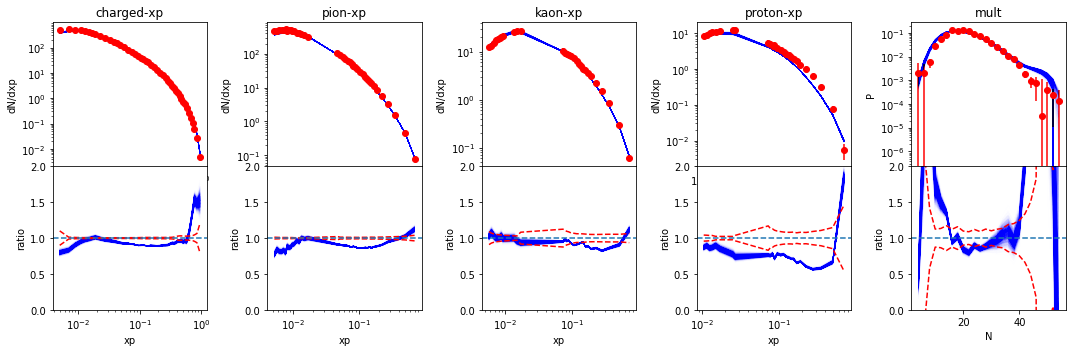

In [16]:
Examples = MCMCSamples[np.random.choice(range(len(MCMCSamples)), 2500), :]
TempPrediction = {"AuAu200": EmulatorAuAu200.predict(Examples)}

makeplot(TempPrediction,"Posteriors")

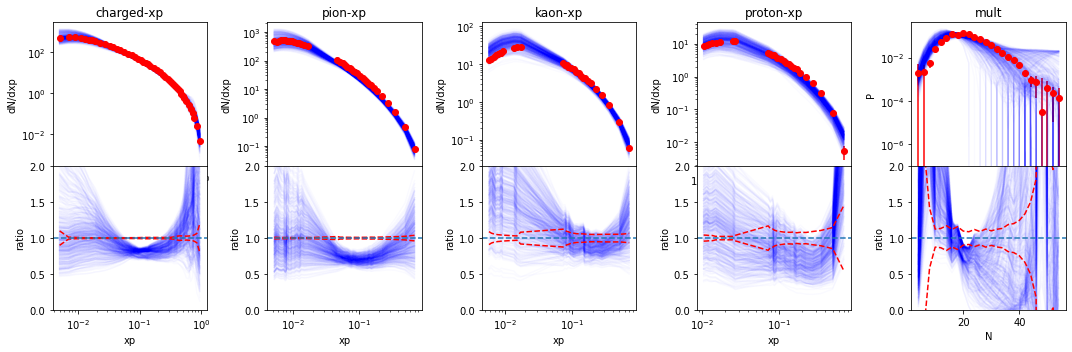

In [17]:
Examples = AllData["design"]
TempPrediction = {"AuAu200": EmulatorAuAu200.predict(Examples)}

makeplot(TempPrediction,"Predicted Design")

Priors

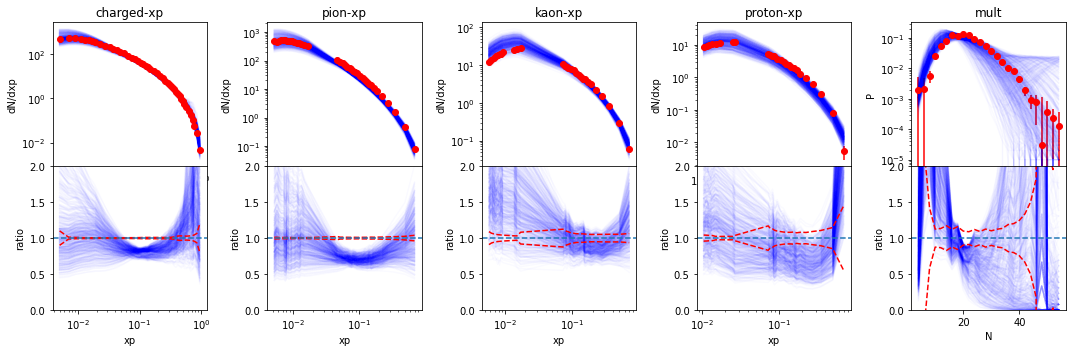

In [18]:
TempPrediction = AllData["model"]

makeplot(TempPrediction,"Priors")

In [19]:
# close all plots to save memory
plt.close('all')